In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error

In [2]:
x = pd.read_csv('data/googletrend_ML.csv', header=1)
x.columns = ['week', 'x']
y = pd.read_csv('data/googletrend_DL.csv', header=1)
y.columns = ['week', 'y']

data = pd.concat([x, y['y']], axis=1)

In [3]:
data.head()

,week,x,y
0,2014-11-23,23,10
1,2014-11-30,23,16
2,2014-12-07,26,16
3,2014-12-14,21,18
4,2014-12-21,18,13


In [4]:
data['week'] = pd.to_datetime(x['week'])

data = data.set_index(data['week'])
data.drop(['week'], axis=1, inplace=True)

In [5]:
data.head()

,x,y
week,,
2014-11-23,23,10
2014-11-30,23,16
2014-12-07,26,16
2014-12-14,21,18
2014-12-21,18,13


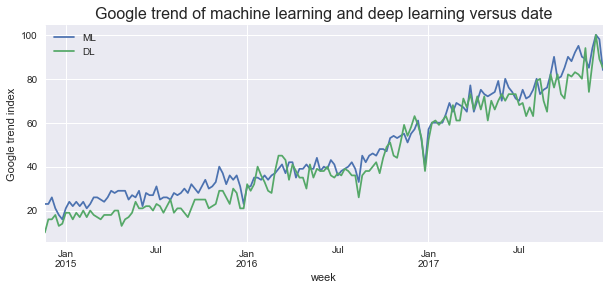

In [6]:
plt.figure(figsize=(10, 4))
plt.xlabel('Dates')
plt.title('Google trend of machine learning and deep learning versus date', fontsize=16)
data['x'].plot(label='ML', legend=True);
plt.ylabel('Google trend index');
data['y'].plot(label='DL', legend=True);  

## Generate lags of x

In [7]:
max_lag = 5 # this value has been tuned
col_names = ['x_lag_' + str(i) for i in range(1, max_lag+1)]

for i, col_name in enumerate(col_names):
    data[col_name] = data['x'].shift(i+1)
    
data.dropna(inplace=True)

In [8]:
data.head()

,x,y,x_lag_1,x_lag_2,x_lag_3,x_lag_4,x_lag_5
week,,,,,,,
2014-12-28,16,14,18.0,21.0,26.0,23.0,23.0
2015-01-04,21,19,16.0,18.0,21.0,26.0,23.0
2015-01-11,24,19,21.0,16.0,18.0,21.0,26.0
2015-01-18,22,16,24.0,21.0,16.0,18.0,21.0
2015-01-25,24,19,22.0,24.0,21.0,16.0,18.0


## Modeling

In [9]:
# train test split: the most recent 20% data as test set
cutoff = int(len(data) * 0.8)
train = data[:cutoff]
test = data[cutoff:]

In [10]:
print(train.shape, test.shape)

(124, 7) (32, 7)


In [11]:
X = train.drop(['y', 'x'], axis=1)
y = train['y']

In [12]:
X.head()

,x_lag_1,x_lag_2,x_lag_3,x_lag_4,x_lag_5
week,,,,,
2014-12-28,18.0,21.0,26.0,23.0,23.0
2015-01-04,16.0,18.0,21.0,26.0,23.0
2015-01-11,21.0,16.0,18.0,21.0,26.0
2015-01-18,24.0,21.0,16.0,18.0,21.0
2015-01-25,22.0,24.0,21.0,16.0,18.0


Time series split

In [13]:
tscv = TimeSeriesSplit(n_splits=3)
splitting_dates = []
for train_i, val_i in tscv.split(X):
    X_val = X.iloc[val_i]
    splitting_dates.append(X_val.index[0])
    print(X.iloc[train_i].shape, X.iloc[val_i].shape)

(31, 5) (31, 5)
(62, 5) (31, 5)
(93, 5) (31, 5)


In [14]:
# save the cutoff dates for plotting later
splitting_dates

[Timestamp('2015-08-02 00:00:00'),
 Timestamp('2016-03-06 00:00:00'),
 Timestamp('2016-10-09 00:00:00')]

In [15]:
tree = DecisionTreeRegressor()
rf = RandomForestRegressor()
xgbr = xgb.XGBRegressor()

regressors = {'decision tree': tree,
              'random forest': rf, 
              'xgboost': xgbr}

In [16]:
def make_predictions(X, y, regressors):
    rmse_results = {}
    
    val_predictions = pd.DataFrame(data=y)
    
    for name, reg in regressors.items():
        reg_name = name
        reg_results = {}
        reg_predictions = np.zeros(len(X))
        fold = 1

        for train_i, val_i in tscv.split(X):
   
            X_train = X.iloc[train_i]
            X_val = X.iloc[val_i]
            y_train = y.iloc[train_i]
            y_val = y.iloc[val_i]

            reg = reg.fit(X_train, y_train)
            prediction_train = reg.predict(X_train)
            prediction_val = reg.predict(X_val)
            reg_predictions[val_i] = prediction_val
            reg_results['train fold '+str(fold)] = np.sqrt(mean_squared_error(y_train, prediction_train))
            reg_results['validation fold '+str(fold)] = np.sqrt(mean_squared_error(y_val, prediction_val))

            # next fold
            fold += 1

        # average result across all folds
        reg_results['validation fold average'] = (reg_results['validation fold 1'] + reg_results['validation fold 2'] + reg_results['validation fold 3']) / 3

        rmse_results[reg_name] = reg_results
        val_predictions[reg_name] = reg_predictions
        
    return pd.DataFrame(rmse_results), val_predictions

In [17]:
rmse_results, val_predictions = make_predictions(X, y, regressors)

In [18]:
rmse_results

,decision tree,random forest,xgboost
train fold 1,0.000000,0.926285,0.000772
validation fold 1,10.920534,9.329732,10.657626
train fold 2,0.000000,1.545104,0.001301
validation fold 2,15.925229,11.169035,15.472795
train fold 3,0.000000,1.762254,0.001721
validation fold 3,18.842300,20.208967,22.695856
validation fold average,15.229354,13.569245,16.275426


In [19]:
val_predictions = val_predictions.loc[splitting_dates[0]:]

In [20]:
val_predictions.head()

,y,decision tree,random forest,xgboost
week,,,,
2015-08-02,25,20.0,20.42,21.027950
2015-08-09,19,21.0,20.60,21.102997
2015-08-16,21,18.0,19.59,19.179806
2015-08-23,21,20.0,19.47,19.741982
2015-08-30,19,22.0,19.32,18.776287


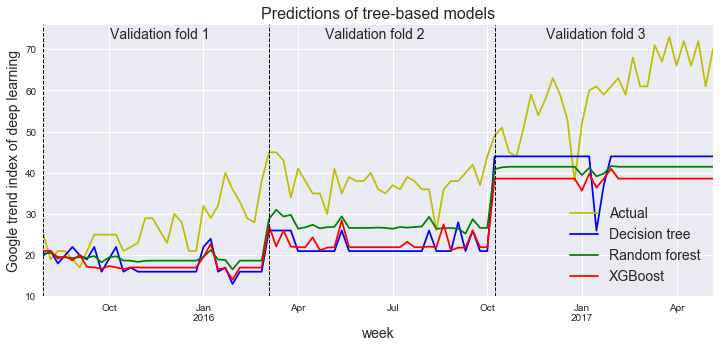

In [58]:
plt.figure(figsize=(12,5))
plt.xlabel('Dates', fontsize=14)
plt.ylabel('Google trend index of deep learning', fontsize=14)
plt.title('Predictions of tree-based models', fontsize=16)
val_predictions['y'].plot(label='Actual', color='y', legend=True);
val_predictions['decision tree'].plot(label='Decision tree', color='b', legend=True);
val_predictions['random forest'].plot(label='Random forest', color='g', legend=True);
val_predictions['xgboost'].plot(label='XGBoost', color='r', legend=True);
plt.legend(loc='lower right', prop={'size': 14})

for date in splitting_dates:
    plt.axvline(date, color='k', linestyle='--', linewidth=1)
    
plt.annotate('Validation fold 1', xy=(0.1, 0.95), fontsize=14, xycoords='axes fraction');
plt.annotate('Validation fold 2', xy=(0.42, 0.95), fontsize=14, xycoords='axes fraction');
plt.annotate('Validation fold 3', xy=(0.75, 0.95), fontsize=14, xycoords='axes fraction');

Plot rmse

In [22]:
rmse_results

,decision tree,random forest,xgboost
train fold 1,0.000000,0.926285,0.000772
validation fold 1,10.920534,9.329732,10.657626
train fold 2,0.000000,1.545104,0.001301
validation fold 2,15.925229,11.169035,15.472795
train fold 3,0.000000,1.762254,0.001721
validation fold 3,18.842300,20.208967,22.695856
validation fold average,15.229354,13.569245,16.275426


Text(0.5, 1.0, 'RMSE of models')

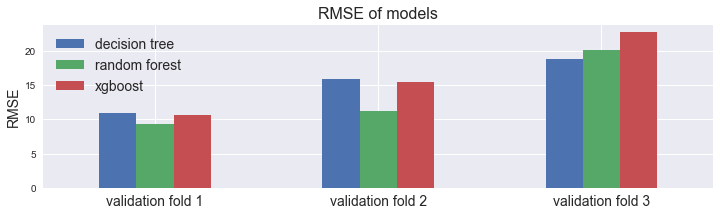

In [23]:
rows_to_plot = ['validation fold 1', 'validation fold 2', 'validation fold 3']
rmse_to_plot = rmse_results.loc[rows_to_plot, :]

rmse_to_plot.plot.bar(figsize=(12, 3), rot=0)
plt.legend(prop={'size': 14})
plt.xticks(fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.title('RMSE of models', fontsize=16)

### Transform x and y

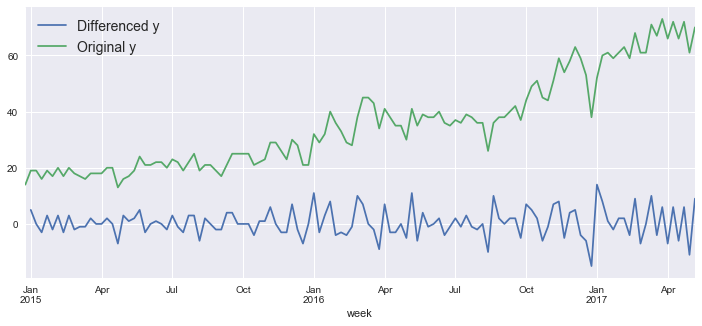

In [48]:
plt.figure(figsize=(12,5))
plt.xlabel('Dates')
train['y'].diff().plot(label='Differenced y', legend=True);
train['y'].plot(label='Original y', legend=True);
plt.legend(prop={'size': 14})

In [25]:
data.head()

,x,y,x_lag_1,x_lag_2,x_lag_3,x_lag_4,x_lag_5
week,,,,,,,
2014-12-28,16,14,18.0,21.0,26.0,23.0,23.0
2015-01-04,21,19,16.0,18.0,21.0,26.0,23.0
2015-01-11,24,19,21.0,16.0,18.0,21.0,26.0
2015-01-18,22,16,24.0,21.0,16.0,18.0,21.0
2015-01-25,24,19,22.0,24.0,21.0,16.0,18.0


In [26]:
X_diff = train.drop(['y', 'x'], axis=1).diff().dropna()
y_diff = train['y'].diff().dropna()

In [27]:
X_diff.head()

,x_lag_1,x_lag_2,x_lag_3,x_lag_4,x_lag_5
week,,,,,
2015-01-04,-2.0,-3.0,-5.0,3.0,0.0
2015-01-11,5.0,-2.0,-3.0,-5.0,3.0
2015-01-18,3.0,5.0,-2.0,-3.0,-5.0
2015-01-25,-2.0,3.0,5.0,-2.0,-3.0
2015-02-01,2.0,-2.0,3.0,5.0,-2.0


In [28]:
y_diff.head()

week
2015-01-04    5.0
2015-01-11    0.0
2015-01-18   -3.0
2015-01-25    3.0
2015-02-01   -2.0
Name: y, dtype: float64

In [29]:
results_diff, val_predictions_diff = make_predictions(X_diff, y_diff, regressors)

In [30]:
results_diff

,decision tree,random forest,xgboost
train fold 1,0.000000,1.173886,0.000865
validation fold 1,4.871687,4.708348,4.762244
train fold 2,0.000000,1.514822,0.001416
validation fold 2,5.446712,4.849176,4.805269
train fold 3,0.000000,1.536676,0.001390
validation fold 3,8.076716,7.275716,7.274927
validation fold average,6.131705,5.611080,5.614146


In [31]:
# remove the frist traning set that has no prediction for y
val_predictions_diff = val_predictions_diff.loc[splitting_dates[0]:]

Text(0.75, 0.95, 'Validation fold 3')

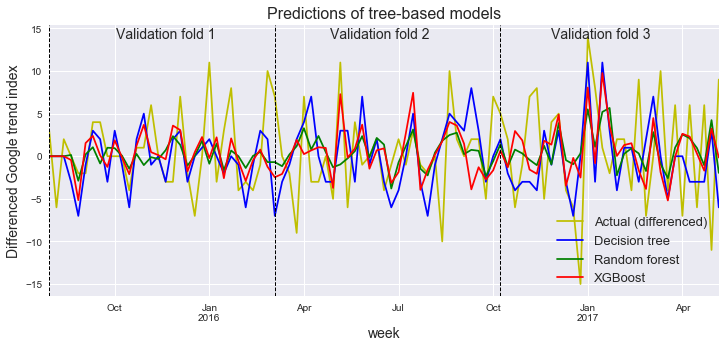

In [57]:
plt.figure(figsize=(12,5))
plt.xlabel('Dates', fontsize=14)
plt.ylabel('Differenced Google trend index', fontsize=14)
plt.title('Predictions of tree-based models', fontsize=16)
val_predictions_diff['y'].plot(label='Actual (differenced)', color='y', legend=True);
val_predictions_diff['decision tree'].plot(label='Decision tree', color='b', legend=True);
val_predictions_diff['random forest'].plot(label='Random forest', color='g', legend=True);
val_predictions_diff['xgboost'].plot(label='XGBoost', color='r', legend=True);
plt.legend(loc='lower right', prop={'size': 13})

for date in splitting_dates:
    plt.axvline(date, color='k', linestyle='--', linewidth=1)
    
plt.annotate('Validation fold 1', xy=(0.1, 0.95), fontsize=14, xycoords='axes fraction')
plt.annotate('Validation fold 2', xy=(0.42, 0.95), fontsize=14, xycoords='axes fraction')
plt.annotate('Validation fold 3', xy=(0.75, 0.95), fontsize=14, xycoords='axes fraction')

Text(0.5, 1.0, 'RMSE of models')

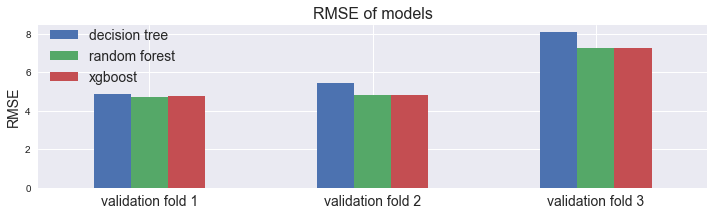

In [52]:
rows_to_plot = ['validation fold 1', 'validation fold 2', 'validation fold 3']
rmse_to_plot = results_diff.loc[rows_to_plot, :]

rmse_to_plot.plot.bar(figsize=(12, 3), rot=0)
plt.legend(loc=(0.01, 0.6), prop={'size': 14})
plt.xticks(fontsize=14)
plt.ylabel('RMSE', fontsize=14)
plt.title('RMSE of models', fontsize=16)

### Convert the predictions back

In [33]:
val_predictions_diff.head()

,y,decision tree,random forest,xgboost
week,,,,
2015-08-02,3.0,0.0,0.00,0.000000
2015-08-09,-6.0,0.0,0.00,0.000000
2015-08-16,2.0,0.0,0.00,0.000000
2015-08-23,0.0,-3.0,0.15,-0.437566
2015-08-30,-2.0,-7.0,-2.88,-5.154151


In [34]:
y.loc[:splitting_dates[0]].tail()

week
2015-07-05    23
2015-07-12    22
2015-07-19    19
2015-07-26    22
2015-08-02    25
Name: y, dtype: int64

We want the actual value of y at 2015-07-26, which is 22:

In [35]:
reference_y_value = y.loc[:splitting_dates[0]][-2]
reference_y_value

22

In [36]:
add_reference_y = pd.DataFrame([[reference_y_value]*4])
add_reference_y.columns = val_predictions_diff.columns

In [37]:
inverse_diff = val_predictions_diff.copy()
inverse_diff = pd.concat([add_reference_y, inverse_diff])

In [38]:
inverse_diff.head()

,y,decision tree,random forest,xgboost
0,22.0,22.0,22.00,22.000000
2015-08-02 00:00:00,3.0,0.0,0.00,0.000000
2015-08-09 00:00:00,-6.0,0.0,0.00,0.000000
2015-08-16 00:00:00,2.0,0.0,0.00,0.000000
2015-08-23 00:00:00,0.0,-3.0,0.15,-0.437566


In [39]:
inverse_diff['decision tree'] = inverse_diff['decision tree'].cumsum()
inverse_diff['random forest'] = inverse_diff['random forest'].cumsum()
inverse_diff['xgboost'] = inverse_diff['xgboost'].cumsum()
inverse_diff['y'] = inverse_diff['y'].cumsum()

In [40]:
inverse_diff.head()

,y,decision tree,random forest,xgboost
0,22.0,22.0,22.00,22.000000
2015-08-02 00:00:00,25.0,22.0,22.00,22.000000
2015-08-09 00:00:00,19.0,22.0,22.00,22.000000
2015-08-16 00:00:00,21.0,22.0,22.00,22.000000
2015-08-23 00:00:00,21.0,19.0,22.15,21.562434


In [41]:
# remove the reference row
inverse_diff = inverse_diff.drop([0])

Plot results

Text(0.75, 0.95, 'Validation fold 3')

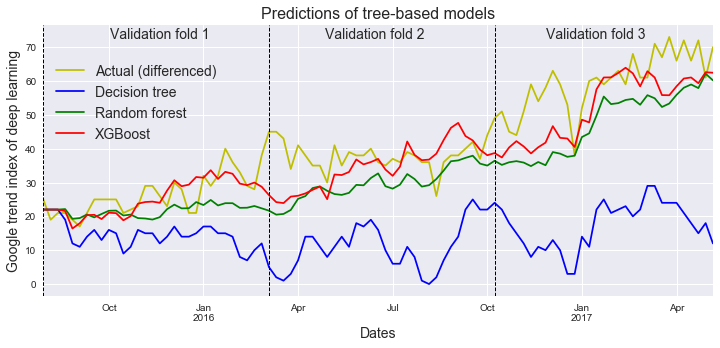

In [60]:
plt.figure(figsize=(12,5))
plt.xlabel('Dates', fontsize=14)
plt.ylabel('Google trend index of deep learning', fontsize=14)
plt.title('Predictions of tree-based models', fontsize=16)
inverse_diff['y'].plot(label='Actual (differenced)', color='y', legend=True);
inverse_diff['decision tree'].plot(label='Decision tree', color='b', legend=True);
inverse_diff['random forest'].plot(label='Random forest', color='g', legend=True);
inverse_diff['xgboost'].plot(label='XGBoost', color='r', legend=True);
plt.legend(loc=(0.01, 0.55), prop={'size': 14})

for date in splitting_dates:
    plt.axvline(date, color='k', linestyle='--', linewidth=1)
    
plt.annotate('Validation fold 1', xy=(0.1, 0.95), fontsize=14, xycoords='axes fraction')
plt.annotate('Validation fold 2', xy=(0.42, 0.95), fontsize=14, xycoords='axes fraction')
plt.annotate('Validation fold 3', xy=(0.75, 0.95), fontsize=14, xycoords='axes fraction')